# Exercise 1.2 - Forward Flux Sampling

In [10]:
from enum import Enum, auto
from pathlib import Path

import numpy as np
import scipy.stats
import scipy.interpolate
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm_

import soft_matter.sample
import soft_matter.energy
import soft_matter.dynamics

In [2]:
NUM_SEGMENTS = 16
A_SEGMENTS = 4
soft_matter.energy.A_SEGMENTS
np.random.seed(42)  # make experiments reproducible
data_dir = Path.cwd() / ".." / "data"
figure_dir = Path.cwd() / ".." / "report" / "figures"

## Define forward flux interfaces

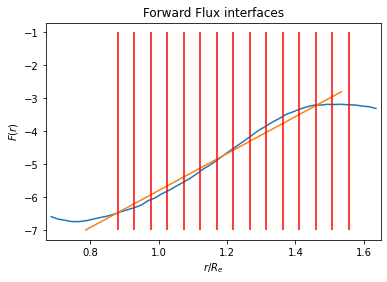

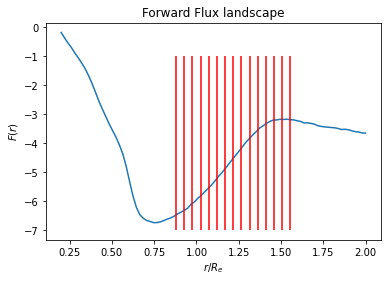

In [108]:
rs, free_energy = np.loadtxt(data_dir / "ex1_free_energy_profile.dat").T
start, end = .72, 1.6
mask = np.logical_and(start - .05 < rs, rs < end + .05)
linreg_mask = np.logical_and(start + .05 < rs, rs < end - .05)

lower = np.min(free_energy[mask])
upper = np.max(free_energy[mask]) + .5  # we want to go far over the barrier
delta_f_spacing = .4
num_interfaces = (upper - lower) // delta_f_spacing + 6  # make a little more and also rounding
linreg = scipy.stats.linregress(rs[linreg_mask], free_energy[linreg_mask])

free_energy_space = np.linspace(lower, upper, num=int(num_interfaces))[1:]
interfaces = (free_energy_space - linreg.intercept) / linreg.slope  # type: ignore

plt.plot(rs[mask], free_energy[mask])
plt.plot(rs[linreg_mask], linreg.slope * rs[linreg_mask] + linreg.intercept)  # type: ignore
for r in interfaces:
    plt.vlines(r, -1, -7, color="r")
plt.xlim(start - .05, end + .05)
plt.ylabel("$F(r)$")
plt.xlabel("$r/R_e$")
plt.title("Forward Flux interfaces")
plt.savefig(figure_dir / "ex2_forward_flux_interfaces.pdf")
plt.show()

plt.plot(rs, free_energy)
for r in interfaces:
    plt.vlines(r, -1, -7, color="r")
plt.ylabel("$F(r)$")
plt.xlabel("$r/R_e$")
plt.title("Forward Flux landscape")
plt.savefig(figure_dir / "ex2_forward_flux_landscape.pdf")
plt.show()

## Generate as many initial configurations as necessary.

In [26]:
drop_start = 10_000
energy = soft_matter.energy.energy_with_external_fields

def initial_configs():
    old_polymer = soft_matter.sample.sample_initial(NUM_SEGMENTS)
    energy_old = energy(old_polymer)

    steps = 1
    while True:
        new_polymer = soft_matter.dynamics.polymer_step(old_polymer)
        energy_new = energy(new_polymer)

        acceptance_rate = np.exp(energy_old - energy_new)
        mc_number = np.random.rand()
        if mc_number < acceptance_rate:  # accepted
            old_polymer = new_polymer
            energy_old = energy_new
        if steps > drop_start and steps % (NUM_SEGMENTS * drop_start // 50) == 0:
            yield old_polymer
        steps += 1

  0%|          | 0/100 [00:00<?, ?it/s]

(array([0.99681535, 2.27843509, 3.70245702, 3.41765263, 1.42402193,
        1.28161974, 0.71201096, 0.14240219, 0.14240219, 0.14240219]),
 array([0.59081348, 0.66103711, 0.73126075, 0.80148439, 0.87170803,
        0.94193166, 1.0121553 , 1.08237894, 1.15260258, 1.22282621,
        1.29304985]),
 <BarContainer object of 10 artists>)

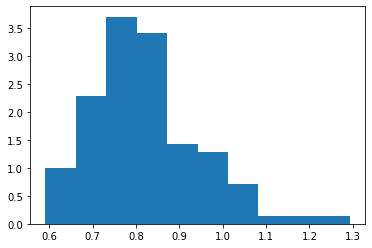

In [28]:
config_generator = initial_configs()
configs = []
for _ in tqdm_(range(100)):
    configs.append(next(config_generator))

configs = map(lambda a: (a[A_SEGMENTS] + a[A_SEGMENTS + 1]) / 2, configs)
configs = list(map(soft_matter.energy.polymer_pos_to_rad, configs))
plt.hist(configs, density=True, stacked=True, bins=10)

## Do some fluxes

In [64]:
max_steps = 100_000

class Result(Enum):
    NOT_REACHED = auto()
    REACHED_UPPER = auto()
    REACHED_LOWER = auto()

def forward_flux_sim(old_polymer, lower, upper):
    energy_old = energy(old_polymer)
    for step in range(max_steps * NUM_SEGMENTS):
        new_polymer = soft_matter.dynamics.polymer_step(old_polymer)
        energy_new = energy(new_polymer)

        acceptance_rate = np.exp(energy_old - energy_new)
        mc_number = np.random.rand()
        if mc_number > acceptance_rate:  # rejected
            continue

        old_polymer = new_polymer
        energy_old = energy_new

        reaction_coordinate = soft_matter.energy.polymer_pos_to_rad(
            (new_polymer[A_SEGMENTS, :] - new_polymer[A_SEGMENTS + 1, :]) / 2
        )
        print(f"{step=} {reaction_coordinate}", end="\r")
        if reaction_coordinate > upper:
            return Result.REACHED_UPPER, new_polymer
        if reaction_coordinate < lower:
            return Result.REACHED_LOWER, None
    else:
        return Result.NOT_REACHED, None

## Sample some configurations that reach the first boundary

In [65]:
def in_basin(trial):
    reaction_coordinate = soft_matter.energy.polymer_pos_to_rad((trial[A_SEGMENTS] + trial[A_SEGMENTS]) / 2)
    print(reaction_coordinate, end="\r")
    if reaction_coordinate > interfaces[0]:
        return False
    else:
        return True

config_generator = initial_configs()
configs = []
not_reached = 0
while len(configs) < 50:
    trial = next(config_generator)
    if not in_basin(trial): continue
    result, config = forward_flux_sim(trial, lower=-1, upper=interfaces[0])
    if result is Result.REACHED_UPPER:
        configs.append(config)
    else:
        not_reached += 1

    print(
        f"Found {len(configs)} viable configurations, other {not_reached} ({len(configs) / (len(configs) + not_reached):.2%}) last: {result}",
        end="\r"
    )


KeyboardInterrupt

